# Телеком — задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

# Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

# Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

# План работы:
1. Загрузка данных и первичных осмотр
2. Предобработка данных: слияние таблиц, приведение к нужному типу данных, работа с пропусками и дубликатами
3. Разделение датасета на тренировочную и тестовую часть, выделение целевого признака
4. Обучение различных моделей и проверка на тестовой выборке
5. Сравнение метрик и выбор оптимальной модели

## Загрузка и первичный осмотр данных

In [1]:
#импорт необходимых библиотек
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

In [2]:
#файл с информацией о договоре

contract = pd.read_csv('/datasets/final_provider/contract.csv')
display(contract.head())
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [3]:
#файл с информацией о персональных данных клиента

personal = pd.read_csv('/datasets/final_provider/personal.csv')
display(personal.head())
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [4]:
#файл с информацией об интернет-услугах

internet = pd.read_csv('/datasets/final_provider/internet.csv')
display(internet.head())
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [5]:
#файл с информацией об услугах телефонии

phone = pd.read_csv('/datasets/final_provider/phone.csv')
display(phone.head())
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


## Предобработка данных: слияние таблиц, приведение к нужному типу данных, работа с пропусками и дубликатами

Во всех датасетах у нас есть общий столбец customerID, который содержит уникальный идентификатор клиента. Для удобства дальнейшего анализа произведем слияние датасетов по customerID, чтобы получить полную информацию по каждому клиенту.

In [6]:
data_cp = contract.merge(personal, on='customerID', how='left')
data_cpi = data_cp.merge(internet, on='customerID', how='left')
data_full = data_cpi.merge(phone, on='customerID', how='left')
display(data_full.head())
data_full.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [7]:
#проверка на дубликаты
data_full.duplicated().sum()

0

In [8]:
#замена пропусков на NO, так как пропуски это клиенты не подключившие данную услугу
data_full = data_full.fillna('No')
data_full.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [9]:
#проверка уникальных значений
len(data_full['customerID'].unique())

7043

In [10]:
display(data_full['EndDate'].unique())
display(data_full['Type'].unique())
display(data_full['PaperlessBilling'].unique())
display(data_full['gender'].unique())
display(data_full['SeniorCitizen'].unique())
display(data_full['Partner'].unique())
display(data_full['Dependents'].unique())
display(data_full['InternetService'].unique())
display(data_full['OnlineSecurity'].unique())
display(data_full['OnlineBackup'].unique())
display(data_full['DeviceProtection'].unique())
display(data_full['TechSupport'].unique())
display(data_full['StreamingTV'].unique())
display(data_full['MultipleLines'].unique())
display(data_full['PaymentMethod'].unique())
display(data_full['MonthlyCharges'].unique())
display(data_full['TotalCharges'].unique())

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['Female', 'Male'], dtype=object)

array([0, 1])

array(['Yes', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['DSL', 'Fiber optic', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['Yes', 'No'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['No', 'Yes'], dtype=object)

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

array([29.85, 56.95, 53.85, ..., 63.1 , 44.2 , 78.7 ])

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

In [11]:
#приведение данных к нужному типу
data_full['BeginDate'] = pd.to_datetime(data_full['BeginDate'], format = '%Y-%m-%d')

Переводя колонку с общей суммой платежей к числовому типу мы обнаружи неявные пропуски ' '. Удалим их из датасета, так как данных значений немного.

In [12]:
data_full = data_full[data_full['TotalCharges'] != ' ']
data_full['TotalCharges'] = data_full['TotalCharges'].astype('float')

Дату окончания договора приводить к типу datetime пока не будем, так как многие клиенты на момент выгрузки данных 1 февраля 2020 продолжали пользоваться услугами, зато используя этот столбец мы можем добавить новый признак, так называемый срок жизни клиента и проанализировать количество дней, в течении которых клиент пользовался услугами компании до момента выгрузки данных.

In [13]:
#создадим функцию для расчета срока жизни клиента в днях
def client_days(row):
    current_day = pd.Timestamp('2020-02-01')
    
    if row['EndDate'] =='No':
        return (current_day-row['BeginDate']).days
    else:
        return (pd.Timestamp(row['EndDate'])-row['BeginDate']).days

data_full['client_days'] = data_full.apply(client_days, axis=1)
display(data_full['client_days'].unique())

array([  31, 1036,   61, 1371,  245,  671,  306,  853, 1888,  396,  488,
       1767, 1491,  761, 2102, 1584, 2163,  304,  641,   30,  365, 1492,
        914, 1431, 2191,  518,   62,  822,  153, 1401, 1033,  335, 2132,
       1918, 1310,  456, 1826,  549, 2010, 1432,  275,   92,  945, 1523,
       1949, 1706,  337,  214, 1279,  276, 1067, 1461,  883, 1979, 1157,
       2071,  975, 1675, 1126, 1095,  303, 1248,  184,   91,  215,  123,
       1006, 2041,  702, 1737,  242, 1857,  457,  427,  610, 1614,  395,
       1218, 1798,  730, 1340,  579,  122, 1645, 1553,  580, 1795,  487,
       1583,  548,  974, 1156, 1309, 1917,  640,  760,  334, 2101,  669,
       1676, 1856,  792,  852, 1217,  699, 1186, 1065, 1703,  273,  607,
       1003, 1369,  609, 1005, 1399, 1887, 1187, 1765, 2129,  638, 1522,
        183, 1064, 1338, 2160,  972,  244,  791,  426, 1125, 1796, 2130,
       1034, 1430,  913, 2040, 1278, 1400, 2009,  944, 1734, 2099, 1764,
        700,  668, 1736, 1370, 1644, 2070,  821, 17

In [14]:
data_full.query('client_days == "0"')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,client_days


Теперь мы можем выделить целевой признак ушел клиент или нет по столбцу EndDate для решения задачи бинарной классификации

In [15]:
#создадим функцию для целевого признака
def left_or_not(row):
    
    if row['EndDate'] =='No':
        return 0
    else:
        return 1

data_full['left_or_not'] = data_full.apply(left_or_not, axis=1)
display(data_full)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,client_days,left_or_not
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,...,DSL,No,Yes,No,No,No,No,No,31,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,1036,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,61,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,1371,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,...,Fiber optic,No,No,No,No,No,No,No,61,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,Male,0,...,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes,730,0
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,Female,0,...,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes,2191,0
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,...,DSL,Yes,No,No,No,No,No,No,337,0
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,Male,1,...,Fiber optic,No,No,No,No,No,No,Yes,123,1


Теперь уберем лишние колонки с датами, которые уже нам не нужны, а также с общей суммой по договору (так как она сильно коррелирует с месячной оплатой и сроком жизни клиента), для обучения модели оставим помесячную сумму оплаты

In [16]:
data_full.drop(columns=['customerID', 'BeginDate','EndDate', 'TotalCharges'], inplace=True)

In [17]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   gender            7032 non-null   object 
 5   SeniorCitizen     7032 non-null   int64  
 6   Partner           7032 non-null   object 
 7   Dependents        7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  MultipleLines     7032 non-null   object 
 16  client_days       7032 non-null   int64  


Мы получили общую таблицу по всем клиентам. Всего в нашем распоряжении 7032 клиента, по каждому клиенту у нас есть следующая информация:
 - Type - тип договора (например Month-to-month - помесячная оплата, One year - оплата за один год)
 - PaperlessBilling - согласен ли клиент получать онлайн счета (да или нет)
 - PaymentMethod - метод оплаты
 - MonthlyCharges - ежемесячный платеж
 - gender - пол
 - SeniorCitizen - статус пенсионера (0 - нет, 1 - да)
 - Partner - наличие супруга или супруги 
 - Dependents - наличие иждивенцев
 - InternetService - тип подключения интернета: цифровая абонентская линия или оптоволоконный кабель, в данном столбце у нас были неполные данные, поэтому клиенты с пропусками в этом столбце вероятно не подключали интернет.
 - OnlineSecurity - подключена ли блокировка небезопасных сайтов или нет, в данном столбце у нас были неполные данные, поэтому клиенты с пропусками в этом столбце не подключали интернет
 - OnlineBackup - подключена ли услуга облака, пропуски - не подключали интернет
 - DeviceProtection - подключен ли антивирус или нет, в данном столбце у нас были неполные данные, поэтому клиенты с пропусками в этом столбце вероятно не подключали интернет
 - TechSupport - подключена ли выделенная линия технической поддержки или нет, пропуски - клиенты не подключали интернет
 - StreamingTV - подключено ли стриминговое телевидение или нет, пропуски - клиенты не подключали интернет
 - StreamingMovies - подключен ли каталог фильмов или нет, пропуски - клиенты не подключали интернет
 - MultipleLines - подключен ли телефонный аппарат к нескольким линиям одновременно или нет, пропуски - клиенты не подключали телефонную связь.
 - client_days - сколько дней клиент использует услуги
 - left_or_not - целевой признак, клиент не ушел 0, ушел 1

## Разделение датасета на тренировочную и тестовую часть, выделение целевого признака. Обучение различных моделей и проверка на тестовой выборке

In [18]:
#кодирование данных
data_ohe = pd.get_dummies(data_full, drop_first=True)

In [19]:
target = data_ohe['left_or_not']
features = data_ohe.drop(['left_or_not'], axis=1)

data_train, data_valid = train_test_split(data_ohe, train_size=0.6, random_state=250722)
data_valid, data_test = train_test_split(data_valid, test_size=0.5, random_state=250722)

features_train = data_train.drop(['left_or_not'], axis=1) 
target_train = data_train['left_or_not']
features_valid = data_valid.drop(['left_or_not'], axis=1) 
target_valid = data_valid['left_or_not']
features_test = data_test.drop(['left_or_not'], axis=1) 
target_test = data_test['left_or_not']

print(features_train.shape)
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(4219, 21)
(4219,)
(1406, 21)
(1406,)
(1407, 21)
(1407,)


In [20]:
#масштабирование признаков
numeric = ['MonthlyCharges', 'client_days']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_train.head())
display(features_valid.head())
display(features_test.head())

,MonthlyCharges,SeniorCitizen,client_days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
2900,0.142839,1,-1.300014,0,0,1,0,1,0,0,...,1,1,0,0,0,0,0,0,0,0
5373,1.337744,0,1.564222,0,1,1,0,1,0,1,...,0,1,0,0,1,1,1,1,1,0
151,0.997528,0,-1.054162,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,1,1
6340,1.060593,0,-0.398559,0,0,1,1,0,0,1,...,0,1,0,0,0,1,1,1,0,1
5998,-1.490198,0,0.621120,0,1,1,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0


,MonthlyCharges,SeniorCitizen,client_days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
4784,-1.506794,0,-1.300014,0,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
6851,0.994209,0,0.212711,0,1,1,0,0,0,1,...,1,1,0,0,0,1,1,1,0,1
530,-1.455346,0,-0.360942,0,1,1,1,0,0,0,...,1,0,1,0,0,0,0,0,0,0
158,-0.023120,0,-0.686057,0,1,0,0,0,1,1,...,1,0,0,1,0,1,0,1,0,0
3584,0.333692,0,-1.012515,0,0,1,0,0,1,1,...,0,1,0,1,0,0,0,0,0,0


,MonthlyCharges,SeniorCitizen,client_days,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,...,Dependents_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,MultipleLines_Yes
1436,0.878038,0,-1.259710,0,0,1,0,1,0,0,...,0,1,0,0,0,1,0,1,0,1
1807,0.378501,0,-1.301357,0,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0
3791,0.137860,0,-1.094466,0,0,1,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
4333,0.849825,0,-0.072100,0,0,1,1,0,0,1,...,0,1,0,1,1,0,1,0,0,1
3640,1.027401,1,-0.155394,0,0,1,0,1,0,1,...,0,1,0,0,1,1,0,0,1,1


In [21]:
#Модель дерево решений
for depth in range(1, 200, 10):
    model_dt = DecisionTreeClassifier(max_depth=depth, random_state=250722, class_weight='balanced')
    model_dt.fit(features_train, target_train)
    predictions_dt = model_dt.predict(features_valid)
    probabilities_valid = model_dt.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    accuracy = accuracy_score(target_valid, predictions_dt)
    print('Модель DecisionTreeRegressor', 
                'Параметры:', depth, 
                'roc_auc_score:', roc_auc_score(target_valid, probabilities_one_valid),
                'Accuracy:', accuracy) 

Модель DecisionTreeRegressor Параметры: 1 roc_auc_score: 0.6587301179499169 Accuracy: 0.5099573257467994
Модель DecisionTreeRegressor Параметры: 11 roc_auc_score: 0.7889426127794921 Accuracy: 0.7773826458036984
Модель DecisionTreeRegressor Параметры: 21 roc_auc_score: 0.7164307753967418 Accuracy: 0.7745376955903271
Модель DecisionTreeRegressor Параметры: 31 roc_auc_score: 0.7147145796990492 Accuracy: 0.7752489331436699
Модель DecisionTreeRegressor Параметры: 41 roc_auc_score: 0.7147145796990492 Accuracy: 0.7752489331436699
Модель DecisionTreeRegressor Параметры: 51 roc_auc_score: 0.7147145796990492 Accuracy: 0.7752489331436699
Модель DecisionTreeRegressor Параметры: 61 roc_auc_score: 0.7147145796990492 Accuracy: 0.7752489331436699
Модель DecisionTreeRegressor Параметры: 71 roc_auc_score: 0.7147145796990492 Accuracy: 0.7752489331436699
Модель DecisionTreeRegressor Параметры: 81 roc_auc_score: 0.7147145796990492 Accuracy: 0.7752489331436699
Модель DecisionTreeRegressor Параметры: 91 roc_

In [22]:
#проверка на тесте
model = DecisionTreeClassifier(max_depth=11, random_state=250722, class_weight='balanced')
model.fit(features_train, target_train) 
predictions_dt = model_dt.predict(features_test)
probabilities_test = model_dt.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
accuracy = accuracy_score(target_test, predictions_dt)
print('Модель DecisionTreeRegressor','roc_auc_score:', roc_auc_score(target_test, probabilities_one_test), 
      'Accuracy:', accuracy) 

Модель DecisionTreeRegressor roc_auc_score: 0.713731243781597 Accuracy: 0.7761194029850746


In [23]:
#Модель случайный лес
for estimator in range(10, 301, 10):
    model_rf = RandomForestClassifier(max_depth = 11, n_estimators=estimator, random_state=250722, class_weight='balanced')
    model_rf.fit(features_train, target_train)
    predictions_rf = model_rf.predict(features_valid)
    probabilities_valid = model_rf.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    print('Модель RandomForestClassifier', 
                'Параметры:', estimator, 
                'roc_auc_score:', roc_auc_score(target_valid, probabilities_one_valid),
                'Accuracy:', accuracy_score(target_valid, predictions_rf))

Модель RandomForestClassifier Параметры: 10 roc_auc_score: 0.8403257175008286 Accuracy: 0.7880512091038406
Модель RandomForestClassifier Параметры: 20 roc_auc_score: 0.8489092651445278 Accuracy: 0.7916073968705548
Модель RandomForestClassifier Параметры: 30 roc_auc_score: 0.8537212929016811 Accuracy: 0.794452347083926
Модель RandomForestClassifier Параметры: 40 roc_auc_score: 0.8535491595008645 Accuracy: 0.7859174964438123
Модель RandomForestClassifier Параметры: 50 roc_auc_score: 0.8526653700996575 Accuracy: 0.786628733997155
Модель RandomForestClassifier Параметры: 60 roc_auc_score: 0.852954400063715 Accuracy: 0.7930298719772404
Модель RandomForestClassifier Параметры: 70 roc_auc_score: 0.8531946160782873 Accuracy: 0.7887624466571835
Модель RandomForestClassifier Параметры: 80 roc_auc_score: 0.8528940249156675 Accuracy: 0.7887624466571835
Модель RandomForestClassifier Параметры: 90 roc_auc_score: 0.8525870108649574 Accuracy: 0.7894736842105263
Модель RandomForestClassifier Параметры:

In [24]:
#проверка на тесте
model_rf = RandomForestClassifier(max_depth=11, n_estimators = 290, random_state=250722, class_weight='balanced')
model_rf.fit(features_train, target_train) 
predictions_rf = model_rf.predict(features_test)
probabilities_test = model_rf.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
accuracy = accuracy_score(target_test, predictions_rf)
print('Модель RandomForestClassifier','roc_auc_score:', roc_auc_score(target_test, probabilities_one_test), 
      'Accuracy:', accuracy) 

Модель RandomForestClassifier roc_auc_score: 0.8512280241008884 Accuracy: 0.7974413646055437


In [25]:
#модель логистической регрессии 
model = LogisticRegression(random_state=250722)
model.fit(features_train, target_train)
answer = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
accuracy = accuracy_score(target_valid, answer)
print('Модель LogisticRegression','roc_auc_score:', roc_auc_score(target_valid, probabilities_one_valid),'Accuracy:', accuracy)

Модель LogisticRegression roc_auc_score: 0.8537662531183122 Accuracy: 0.7958748221906117


In [26]:
#проверка на тесте
model = LogisticRegression(random_state=250722)
model.fit(features_train, target_train)
answer = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
accuracy = accuracy_score(target_test, answer)
print('Модель LogisticRegression','roc_auc_score:', roc_auc_score(target_test, probabilities_one_test),'Accuracy:', accuracy)

Модель LogisticRegression roc_auc_score: 0.8306877237993747 Accuracy: 0.7903340440653873


In [27]:
#модель Catboost

data_train_ct, data_valid_ct = train_test_split(data_full, train_size=0.6, random_state=250722)
data_valid_ct, data_test_ct = train_test_split(data_valid_ct, test_size=0.5, random_state=250722)

features_train_ct = data_train_ct.drop(['left_or_not'], axis=1) 
target_train_ct = data_train_ct['left_or_not']
features_valid_ct = data_valid_ct.drop(['left_or_not'], axis=1) 
target_valid_ct = data_valid_ct['left_or_not']
features_test_ct = data_test_ct.drop(['left_or_not'], axis=1) 
target_test_ct = data_test_ct['left_or_not']

print(features_train_ct.shape)
print(target_train_ct.shape)
print(features_valid_ct.shape)
print(target_valid_ct.shape)
print(features_test_ct.shape)
print(target_test_ct.shape)

(4219, 17)
(4219,)
(1406, 17)
(1406,)
(1407, 17)
(1407,)


In [28]:
cat_features = ['Type', 'PaperlessBilling', 'PaymentMethod', 
                'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 
                'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
                'StreamingMovies', 'MultipleLines']

In [29]:
model = CatBoostClassifier(loss_function="Logloss", iterations=500, random_state=250722)

model.fit(features_train_ct, target_train_ct, cat_features=cat_features, verbose=10)
predictions = model.predict(features_valid_ct)
probabilities_valid = model.predict_proba(features_valid_ct)
probabilities_one_valid = probabilities_valid[:, 1]
print(roc_auc_score(target_valid_ct, probabilities_one_valid))
print(accuracy_score(target_valid, predictions))

Learning rate set to 0.03597
0:	learn: 0.6690323	total: 56.4ms	remaining: 28.1s
10:	learn: 0.5190775	total: 118ms	remaining: 5.26s
20:	learn: 0.4554130	total: 171ms	remaining: 3.9s
30:	learn: 0.4253072	total: 225ms	remaining: 3.4s
40:	learn: 0.4107361	total: 272ms	remaining: 3.04s
50:	learn: 0.3968545	total: 327ms	remaining: 2.88s
60:	learn: 0.3906447	total: 373ms	remaining: 2.68s
70:	learn: 0.3826126	total: 431ms	remaining: 2.61s
80:	learn: 0.3774114	total: 491ms	remaining: 2.54s
90:	learn: 0.3726495	total: 545ms	remaining: 2.45s
100:	learn: 0.3687280	total: 614ms	remaining: 2.42s
110:	learn: 0.3659304	total: 671ms	remaining: 2.35s
120:	learn: 0.3624215	total: 740ms	remaining: 2.32s
130:	learn: 0.3592591	total: 808ms	remaining: 2.27s
140:	learn: 0.3568525	total: 864ms	remaining: 2.2s
150:	learn: 0.3549032	total: 931ms	remaining: 2.15s
160:	learn: 0.3533110	total: 995ms	remaining: 2.09s
170:	learn: 0.3508998	total: 1.07s	remaining: 2.07s
180:	learn: 0.3494491	total: 1.14s	remaining: 2s

In [30]:
#проверка на тесте
model = CatBoostClassifier(loss_function="Logloss", iterations=500, random_state=250722)

model.fit(features_train_ct, target_train_ct, cat_features=cat_features, verbose=10)
predictions = model.predict(features_test_ct)
probabilities_test = model.predict_proba(features_test_ct)
probabilities_one_test = probabilities_test[:, 1]
print(roc_auc_score(target_test_ct, probabilities_one_test))
print(accuracy_score(target_test, predictions))

Learning rate set to 0.03597
0:	learn: 0.6690323	total: 6.75ms	remaining: 3.37s
10:	learn: 0.5190775	total: 66.3ms	remaining: 2.94s
20:	learn: 0.4554130	total: 122ms	remaining: 2.79s
30:	learn: 0.4253072	total: 178ms	remaining: 2.69s
40:	learn: 0.4107361	total: 225ms	remaining: 2.52s
50:	learn: 0.3968545	total: 280ms	remaining: 2.47s
60:	learn: 0.3906447	total: 324ms	remaining: 2.33s
70:	learn: 0.3826126	total: 394ms	remaining: 2.38s
80:	learn: 0.3774114	total: 454ms	remaining: 2.35s
90:	learn: 0.3726495	total: 509ms	remaining: 2.29s
100:	learn: 0.3687280	total: 578ms	remaining: 2.28s
110:	learn: 0.3659304	total: 643ms	remaining: 2.25s
120:	learn: 0.3624215	total: 709ms	remaining: 2.22s
130:	learn: 0.3592591	total: 771ms	remaining: 2.17s
140:	learn: 0.3568525	total: 835ms	remaining: 2.12s
150:	learn: 0.3549032	total: 892ms	remaining: 2.06s
160:	learn: 0.3533110	total: 943ms	remaining: 1.99s
170:	learn: 0.3508998	total: 1s	remaining: 1.93s
180:	learn: 0.3494491	total: 1.04s	remaining: 1

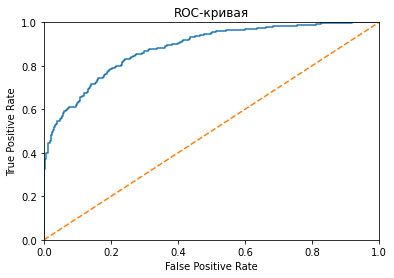

In [31]:
fpr, tpr, thresholds = fpr, tpr, thresholds = roc_curve(target_test_ct, probabilities_one_test)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 

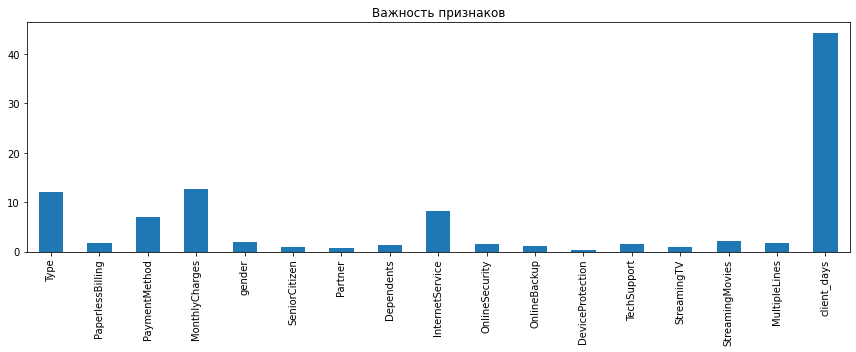

In [32]:
cat_imp = pd.Series(model.get_feature_importance(),
                          data_train_ct.drop(['left_or_not'], axis=1).columns)
fig, ax = plt.subplots(figsize=(12,5))
cat_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
fig.tight_layout()

## Сравнение метрик и выбор оптимальной модели

Мы провели обучение моделей решающего дерева, случайного леса, логистической регрессии и градинетного бустинга Catboost. 

У модели решающего дерева лучшая метрика наблюдается при глубине 11  roc_auc_score: 0.7137 Accuracy: 0.776

У модели случайного леса лучшая метрика наблюдается при глубине 11 и 290 дереверьев roc_auc_score: 0.8512 Accuracy: 0.797

У модели логистической регрессии roc_auc_score: 0.83068 Accuracy: 0.790

И самой лучшей моделью по метрике AUC-ROC стала модель Catboost при 500 итераций с AUC-ROC - 0.88149 Accuracy: 0.842

Также у модели Catboost мы построили график важности признаков и на основании этого графика можно сделать вывод, что самыми важными признаками являются сколько дней клиент уже пользуется услугами, тип договора (чаще всего клиенты уходят с помесячного типа оплаты), ежемесячная плата, интернет услуги и способ оплаты.

## Отчет

# Какие пункты плана были выполнены, а какие — нет ?
В целом все пункты плана были выполнены, а именно была проведена загрузка данных и их первичных осмотр, слияние таблиц, приведение к нужному типу данных, работа с пропусками и дубликатами. Я отказалась от приведение даты окончания договора к нужному типу, так как в конечном итоге данные этой колонки были удалены, чтобы не образовалась "утечка" данных и это не исказило корректную работу модели. Третий пункт плана был дополнен и разделение датасета помимо тренировочной и тестовой части, было дополнено выделением валидационной части (так как подбор осуществлялся в цикле, а не на кросс-валидации), также было выделение целевого признака. 4 и 5 пункты плана были выполнены полностью, было обучено 4 модели, посчитаны метрики и проверены на тестовой выборке, затем была выбрана модель с наилучшими показателями.

#  Какие трудности возникли и как вы их преодолели?
Первая трудность с переводом EndDate. Решение удалить данный столбец, предварительно создав целевой признак на его основе и добавив столбец "срок жизни клиента". Вторая трудность с составления графика важностей факторов, так как я раньше не сталкивалась с таким заданием. Но изучив документацию, все получилось. Третья трудность - это несбалансированная классификация, я проверила модели и их результаты сначала на сырых данных, потом на сбалансированных, после балансировки некоторые показатели метрик выросли. 4ая - подсчет количества дней жизни клиента, но прочитав про метод .days, а также пообщавшись с коллегами у меня получилась удобная функция, которая дополняет таблицу с данными.

# Какие ключевые шаги в решении задачи выделили?
Здесь все было достаточно стандартно:

предобработка данных;
выбор моделей классификации, подготовка признаков
обучение моделей, подбор параметров
сравнение моделей по метрикам
#  Какая ваша итоговая модель и какое у неё качество?

Итоговая модель Catboost с AUC-ROC - 0.88149 Accuracy: 0.842 на тестовой выборке (500 итераций)